## Pandas analysis

In the following a series of exercises is proposed on a dataset containg timing information from a series of Time-to-Digital-Converters (TDC) implemented in a couple of FPGA's. Each measurement (i.e. each raw) consists of the address of the TDC providing the signal, 'FPGA' and 'TDC_Channel, and the timing information itself, 'ORBIT_CNT', 'BX_COUNTER' and 'TDC_MEAS'. Each TDC count correspond 25/30 ns, whereas the BX_COUNTER feauters gets updated every 25 ns and the ORBIT_CNT every 'x' BX_COUNTER. You can see these way of storing the time as similar to hours, minutes and seconds.

1\. Create a Pandas DataFrame by read N raws of the 'data_000637.txt' dataset. Choose N to be smaller than or equal to the maximum number of raws and larger that 10k.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

file_name = "/home/mango/Documents/unipd/magistrale/LaboratoryOfComputationalPhysics/data_000637.txt"
data = pd.read_csv(file_name, nrows=1e5, skiprows=range(1, 1))

2\. Find out the value of 'x'

In [2]:
x = data["BX_COUNTER"].max()
print(x)

3563


3\. Find out how much the data taking lasted. You can either make an estimate on the baseis of the fraction of the measurements (raws) you read, or perform this check precisely by reading out the whole dataset

In [3]:
# Assuming that BX_COUNTER is shared among channels (which is not obvous), the time should be:
full_dataset = pd.read_csv(file_name, skiprows = range(1, 1))

ORBIT_CNT_max = full_dataset["ORBIT_CNT"].max()
ORBIT_CNT_min = full_dataset["ORBIT_CNT"].min()
TDC_MEAS_max = full_dataset["TDC_MEAS"].max()
estimated_time = (ORBIT_CNT_max - ORBIT_CNT_min) * x * TDC_MEAS_max * 25 # ns
print("My estimation of the time elapsed is: ", estimated_time / 1e9, "s")

My estimation of the time elapsed is:  28.4252577 s


4\. Create a new column with the actual time in ns (as a combination of the other three columns with timing information)

In [5]:
def summarize(*args):
    value = 0
    for arg in args:
        value += arg
    return value
    
data['TIME'] = np.vectorize(summarize)((data["ORBIT_CNT"]-ORBIT_CNT_min)*x, data["BX_COUNTER"]*TDC_MEAS_max, data["TDC_MEAS"]*25)
data[10:20]

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,TIME
10,1,1,7,3869200167,2785,4,80865
11,1,0,64,3869200167,2786,19,81269
12,1,1,6,3869200167,2792,18,81418
13,1,0,36,3869200167,2791,23,81514
14,1,0,56,3869200167,2789,3,80956
15,1,1,139,3869200167,2797,0,81113
16,1,1,8,3869200167,2787,14,81173
17,1,0,63,3869200167,2790,10,81160
18,1,1,5,3869200167,2795,4,81155
19,1,0,53,3869200167,2796,26,81734


5\. Replace the values (all 1) of the HEAD column randomly with 0 or 1

In [6]:
data["HEAD"] = np.random.randint(0, 2, data.shape[0])

6\. Create a new DataFrame with only the raws with HEAD=1

In [7]:
filtered_df = data[data["HEAD"] == 1]

7\. Make two occupancy plots (one per FPGA), i.e. plot the number of counts per TDC channel

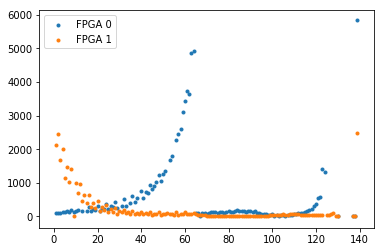

In [8]:
TCSs0 = data[data["FPGA"] == 0]['TDC_CHANNEL'].value_counts()
TCSs1 = data[data["FPGA"] == 1]['TDC_CHANNEL'].value_counts()

plt.scatter(TCSs0.index, TCSs0.values, marker = '.', label = 'FPGA 0')
plt.scatter(TCSs1.index, TCSs1.values, marker = '.', label = 'FPGA 1')
plt.legend()


8\. Use the groupby method to find out the noisy channels, i.e. the TDC channels with most counts (say the top 3)

In [9]:
noisy_channels = [1,1,1]
dictionary = data.groupby(["TDC_CHANNEL"]).groups
for key in dictionary:
    if dictionary[noisy_channels[0]].shape[0] < dictionary[key].shape[0]:
        noisy_channels[2] = noisy_channels[1]
        noisy_channels[1] = noisy_channels[0]
        noisy_channels[0] = key
        
    
noisy_channels

[139, 64, 63]

9\. Count the number of unique orbits. Count the number of unique orbits with at least one measurement from TDC_CHANNEL=139

In [10]:
# orbits = data["ORBIT_CNT"].max() - data["ORBIT_CNT"].min() <- lead to the wrong result
orbits = len(data.groupby(["ORBIT_CNT"]).groups.keys())
orbits_with_139 = len(data[data["TDC_CHANNEL"] == 139].groupby(["ORBIT_CNT"]).groups.keys())

print(orbits)
print(orbits_with_139)


995
994
